In [1]:
cd /home/c01muya/vae-disentanglement/disentanglement_lib_pl

/home/c01muya/vae-disentanglement/disentanglement_lib_pl


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

import torch, torchvision
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

from vae_experiment import VAEExperiment
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
from notebook_utils import *

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

In [3]:
curr_dev = torch.device("cuda:6")
batch_size = 144
seed = 123

In [4]:
beta = 1.0
z_dim = 2
batch_size = 64
checkpoint_path="../pl-dt-test/3shapesnoisy_beta1/version_0/checkpoints/epoch=99-step=13999.ckpt"


acts_for_threeshapesn, threeshapesn_dataset, model_threeshapesn = load_model_and_data_and_get_activations(
                    dset_name='threeshapesnoisy', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=curr_dev, 
                    activation_with_label=True, seed=123,  batches=None
    )


100%|████████████████████████████████████████████| 140/140 [00:03<00:00, 40.36it/s]


torch.Size([32, 1, 4, 4])


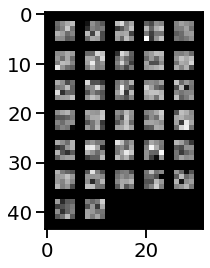

In [22]:

for c, comp in enumerate(model_threeshapesn.model.encoder.main):
    
    if c == 0:
        
        first_layer_kernels = comp.weight.cpu().detach().clone()
        print(first_layer_kernels.size())
        
        # normalize to (0,1) range so that matplotlib can plot them
        first_layer_kernels = first_layer_kernels - first_layer_kernels.min()
        first_layer_kernels = first_layer_kernels / first_layer_kernels.max()
        
        filter_img = torchvision.utils.make_grid(first_layer_kernels, nrow = 5)
        # change ordering since matplotlib requires images to 
        # be (H, W, C)
        plt.imshow(filter_img.permute(1, 2, 0))


In [4]:
beta = 1.0
z_dim = 6
batch_size = 256
checkpoint_path="../pl-dt-test/dsprites_full_beta1/version_0/checkpoints/epoch=51-step=539135.ckpt"


acts_for_dsprites_full, dsprites_full_dataset, model_dsprites_full  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_full', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=curr_dev, 
                    activation_type='without_labels', seed=123,  batches=2000
    )



Loaded 737280 images


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2000/2592 [00:15<00:04, 127.94it/s]


### How input changes as it goes through the network

In [90]:
# dsprites_full_dataloader = DataLoader(dsprites_full_dataset,
#                              batch_size=1,
#                              shuffle=False,
#                              num_workers=8)

result, _ = next(iter(dsprites_full_dataloader))
print(result.shape)
result = result.to(curr_dev)
print("Encoder")
for c, comp in enumerate(model_dsprites_full.model.encoder.main):
    
    print("Operation: ", c, comp)   
    result = comp(result)
    print("Ouput : ", result.shape)
    print()

print("Decoder")
result = result[:, :z_dim]

results = []
print(result.shape)
for c, de_comp in enumerate(model_dsprites_full.model.decoder.main):
    print("Operation: ", c, de_comp)
    result = de_comp(result)
    results.append(result)
    print("Ouput : ", result.shape)
    print()

torch.Size([1, 1, 64, 64])
Encoder
Operation:  0 Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Ouput :  torch.Size([1, 32, 32, 32])

Operation:  1 ReLU(inplace=True)
Ouput :  torch.Size([1, 32, 32, 32])

Operation:  2 Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Ouput :  torch.Size([1, 32, 16, 16])

Operation:  3 ReLU(inplace=True)
Ouput :  torch.Size([1, 32, 16, 16])

Operation:  4 Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Ouput :  torch.Size([1, 64, 8, 8])

Operation:  5 ReLU(inplace=True)
Ouput :  torch.Size([1, 64, 8, 8])

Operation:  6 Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Ouput :  torch.Size([1, 128, 4, 4])

Operation:  7 ReLU(inplace=True)
Ouput :  torch.Size([1, 128, 4, 4])

Operation:  8 Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Ouput :  torch.Size([1, 256, 2, 2])

Operation:  9 ReLU(inplace=True)
Ouput :  torch.Size([1, 256, 2, 2])

Operation:  10 Conv2d(256,

torch.Size([1, 64, 64])
torch.Size([1, 32, 32, 32])
torch.Size([1, 1, 32, 32])


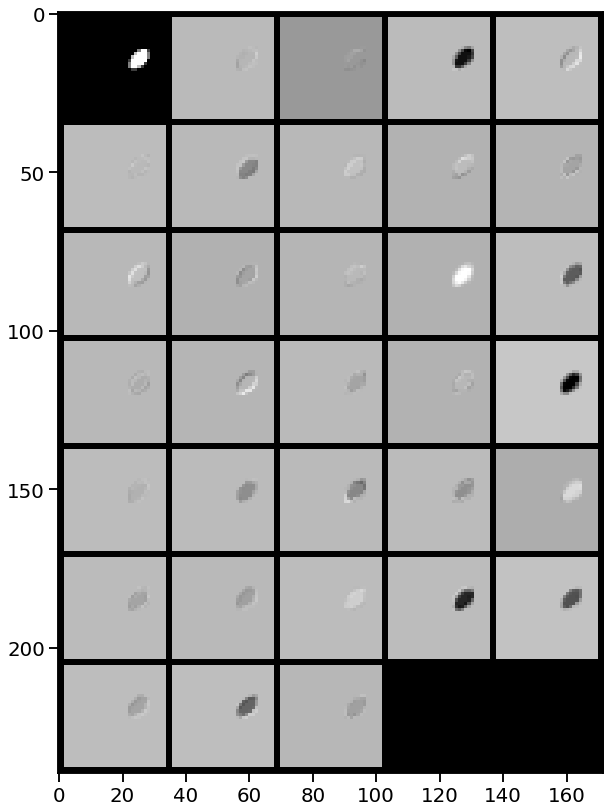

In [77]:
from skimage.transform import resize

anchor_image = dsprites_full_dataset.__getitem__(10000)[0]
print(anchor_image.shape)

anchor_image_resized = resize(anchor_image.permute(1,2,0), (32, 32), order=2)
#print(anchor_image_resized.shape)

#fig, ax = plt.subplots(figsize=(1,1))
#ax.imshow(anchor_image.permute(1,2,0), cmap='gray')

anchor_image = anchor_image.unsqueeze(0)
anchor_image = anchor_image.to(curr_dev)
first_layer_act = model_dsprites_full.model.encoder.main[0](anchor_image)
first_layer_act = first_layer_act.cpu().detach().clone()

print(first_layer_act.shape)
# normalize to (0,1) range so that matplotlib can plot them
first_layer_act = first_layer_act - first_layer_act.min()
first_layer_act = first_layer_act / first_layer_act.max()
first_layer_act = first_layer_act.permute(1,0,2,3)

anchor_as_tensor = transforms.ToTensor()(anchor_image_resized).unsqueeze(0)
print(anchor_as_tensor.shape)
first_layer_act = torch.cat([anchor_as_tensor, first_layer_act], dim = 0)

filter_img = torchvision.utils.make_grid(first_layer_act, nrow = 5)
# change ordering since matplotlib requires images to 
# be (H, W, C)
fig , ax = plt.subplots(figsize=(10,14))
ax.imshow(filter_img.permute(1, 2, 0), cmap='gray')

In [17]:
# Decoder
# torch.Size([1, 6])
# Operation:  0 Unsqueeze3D()
# Ouput :  torch.Size([1, 6, 1, 1])

# Operation:  1 Conv2d(6, 256, kernel_size=(1, 1), stride=(2, 2))
# Ouput :  torch.Size([1, 256, 1, 1])

# Transposeconv: https://indico.cern.ch/event/996880/contributions/4188468/attachments/2193001/3706891/ChiakiYanagisawa_20210219_Conv2d_and_ConvTransposed2d.pdf

with torch.no_grad():
    
    probe = torch.Tensor([
        [1.,2.],
        [3.,4.]
    ]).unsqueeze(0).unsqueeze(0)
    res = torch.nn.Conv2d(1,2,kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))(probe)
    
    lin_probe = torch.Tensor([[
        1., 2.
    ]]).unsqueeze(-1).unsqueeze(-1)
    
    conv_t = torch.nn.ConvTranspose2d(2, 3, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
    lin_res = conv_t(lin_probe)
    #print(conv_t.weight)
    
#print(probe.shape)
#print(res)
#print(res.shape)

print(lin_probe.shape)
print(lin_res)
print(lin_res.shape)

torch.Size([1, 2, 1, 1])
tensor([[[[-0.2663, -0.1327],
          [-0.3559,  0.4751]],

         [[-0.2042,  0.1223],
          [-0.1019, -0.2815]],

         [[ 0.8306,  0.5507],
          [ 0.8364,  0.0830]]]])
torch.Size([1, 3, 2, 2])


In [7]:
len(results)

14

In [9]:
for r in results: print(r.shape)

torch.Size([1, 6, 1, 1])
torch.Size([1, 256, 1, 1])
torch.Size([1, 256, 1, 1])
torch.Size([1, 256, 2, 2])
torch.Size([1, 256, 2, 2])
torch.Size([1, 128, 6, 6])
torch.Size([1, 128, 6, 6])
torch.Size([1, 128, 14, 14])
torch.Size([1, 128, 14, 14])
torch.Size([1, 64, 30, 30])
torch.Size([1, 64, 30, 30])
torch.Size([1, 64, 62, 62])
torch.Size([1, 64, 62, 62])
torch.Size([1, 1, 64, 64])


In [91]:
nrow_vals = [6, 25, 15, 15, 15, 15, 10, 1]

def visualize_internal_layer(to_vis, nrow_val, figsize=(10,14)):
    
    print(to_vis.shape)
    to_vis = to_vis.cpu()
    #to_vis = to_vis - to_vis.min()
    #to_vis = to_vis / to_vis.max()
    to_vis = to_vis.permute(1,0,2,3)

    filter_img = torchvision.utils.make_grid(to_vis, nrow = nrow_val, pad_value=1.0, normalize=True)
    # change ordering since matplotlib requires images to 
    # be (H, W, C)
    fig , ax = plt.subplots(figsize=figsize)
    ax.imshow(filter_img.permute(1, 2, 0), cmap='gray')


torch.Size([1, 6, 1, 1])


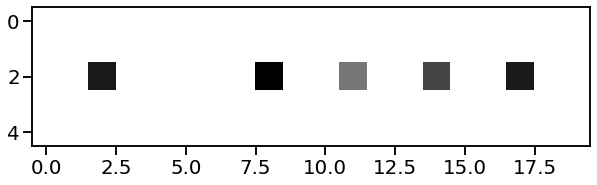

In [92]:
visualize_internal_layer(results[0], nrow_val=6)

torch.Size([1, 256, 1, 1])


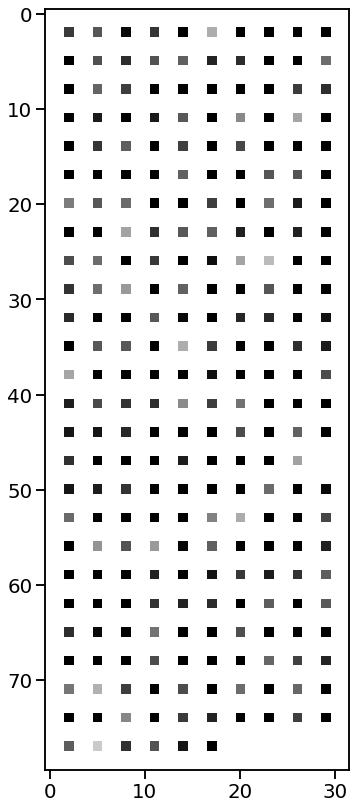

In [93]:
visualize_internal_layer(results[2], nrow_val=10)

torch.Size([1, 256, 2, 2])


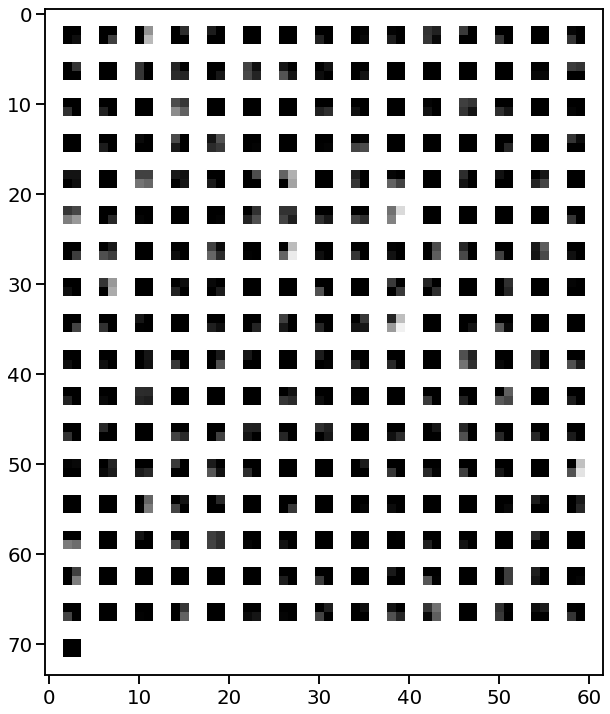

In [94]:
visualize_internal_layer(results[4], nrow_val=15)

torch.Size([1, 128, 6, 6])


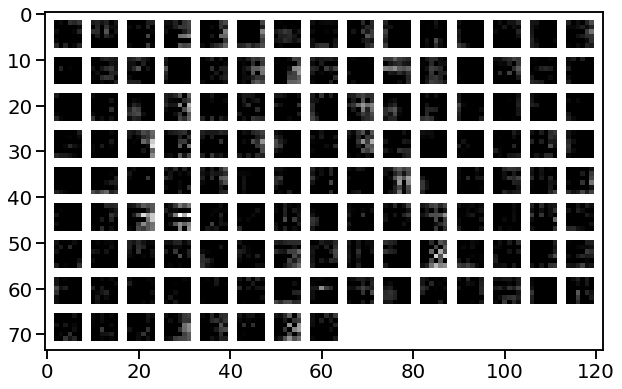

In [95]:
visualize_internal_layer(results[6], nrow_val=15)

torch.Size([1, 128, 14, 14])


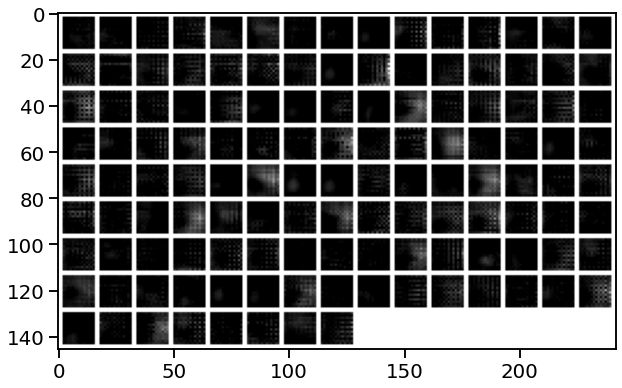

In [96]:
visualize_internal_layer(results[8], nrow_val=15)

torch.Size([1, 64, 30, 30])


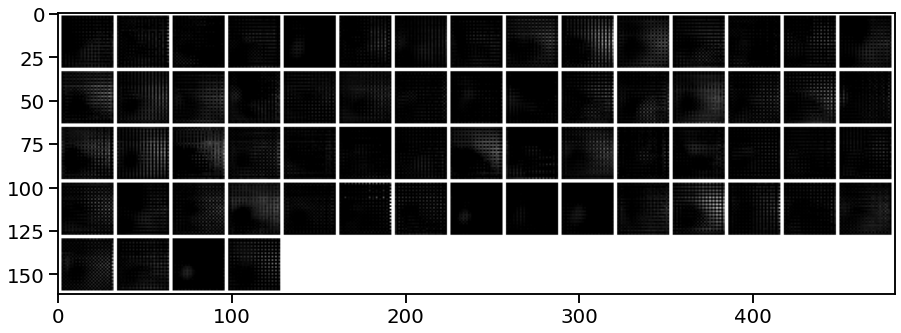

In [97]:
visualize_internal_layer(results[10], nrow_val=15, figsize=(15,10))

torch.Size([1, 64, 62, 62])


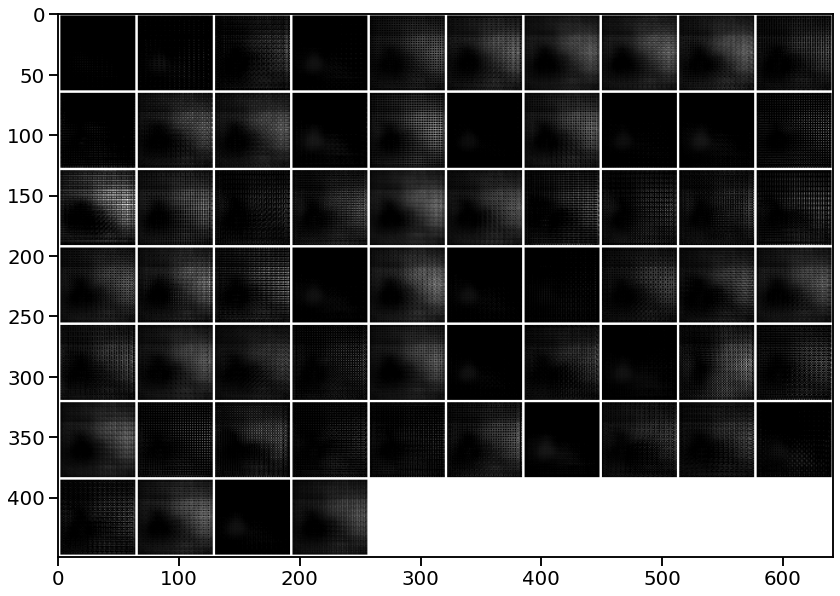

In [98]:
visualize_internal_layer(results[11], nrow_val=10, figsize=(15,10))

torch.Size([1, 64, 62, 62])


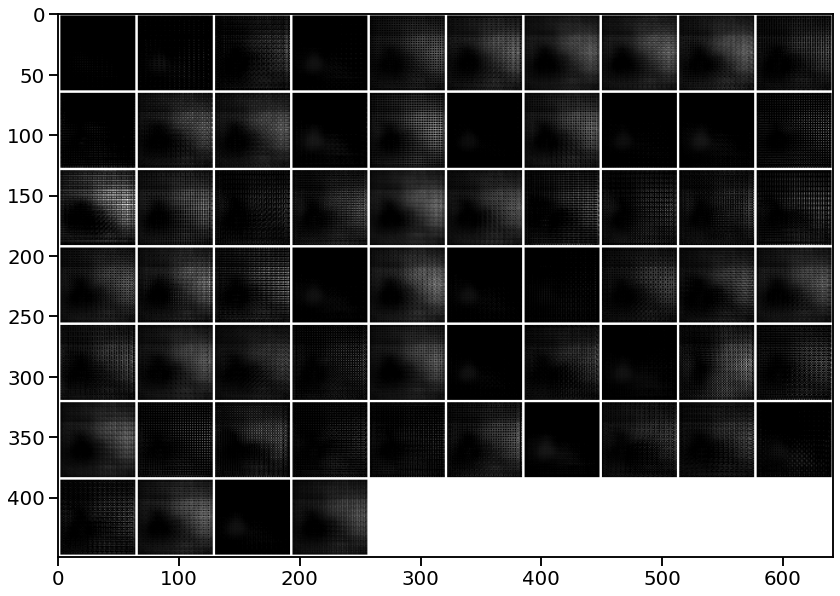

In [99]:
visualize_internal_layer(results[12], nrow_val=10, figsize=(15,10))

torch.Size([62, 62])


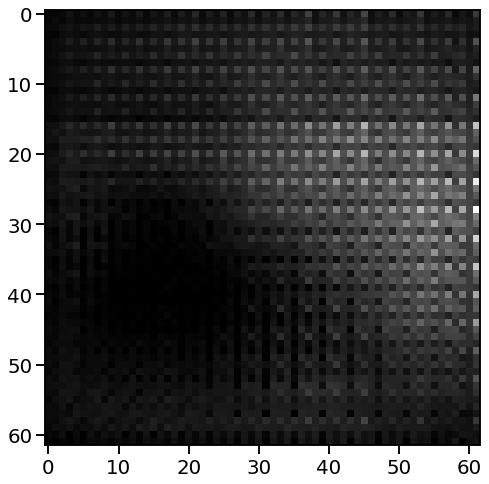

In [100]:
to_vis = results[12][0][11]
print(to_vis.shape)

to_vis = to_vis.cpu()
#to_vis = to_vis - to_vis.min()
#to_vis = to_vis / to_vis.max()
#to_vis = to_vis.permute(1,0,2,3)

filter_img = torchvision.utils.make_grid(to_vis, nrow = 1, pad_value=1.0, normalize=True)
# change ordering since matplotlib requires images to 
# be (H, W, C)
fig , ax = plt.subplots(figsize=(8,8))
ax.imshow(filter_img.permute(1, 2, 0), cmap='gray')


torch.Size([1, 1, 64, 64])


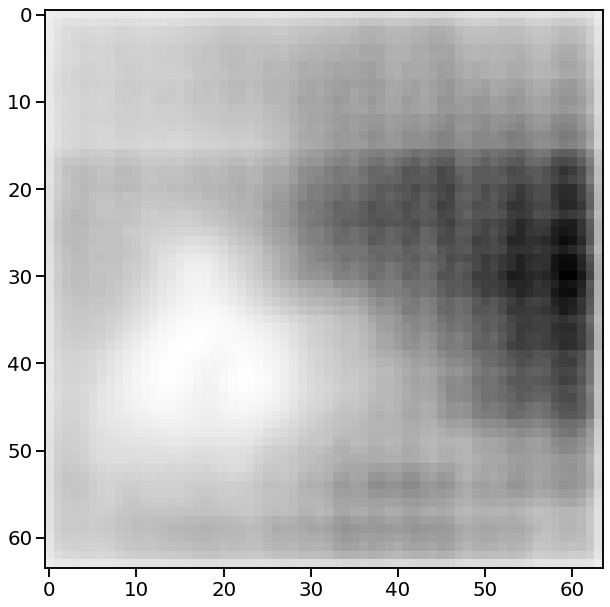

In [101]:
visualize_internal_layer(results[13], nrow_val=1)

torch.Size([1, 1, 64, 64])


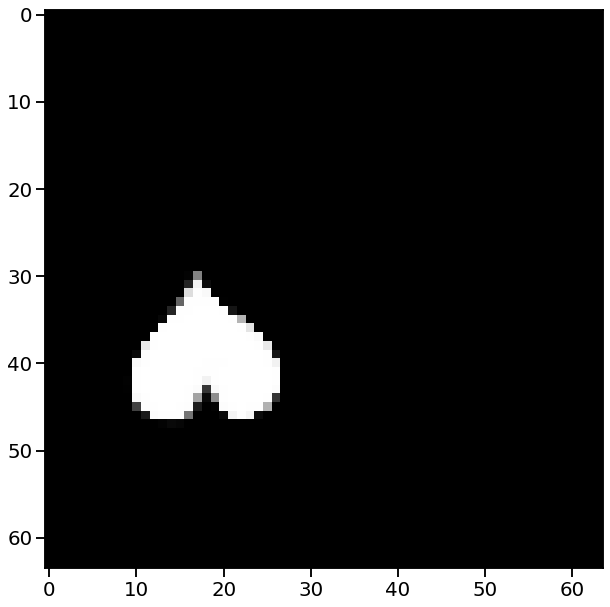

In [102]:
visualize_internal_layer( torch.sigmoid(results[13]), nrow_val=1)